In [56]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import pare, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_approval_villager, 
    random_coordinated_approval_villager, 
    random_agent,
    random_approval_wolf,
    revenge_approval_wolf,
    coordinated_revenge_approval_wolf,
    random_likes_approval_wolf,
    aggressive_approval_wolf,
    )
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate
import pandas as pd

### Oracle Approval Voting

To test the theory that agents have learned how somewhat trust eachother based on likes and neutrals, we introduce a single oracle villager that likes every villager and dislikes every werewolf every single turn, except for voting rounds, where they abstain from voting altogether.

The thought process behind this is that even though villagers lose a valuable vote, the oracle's voting pattern will overcome this

In [5]:
env = pare(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()
obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_approval_agent = ActorCriticAgent({"rec_hidden_size": 256,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)
trained_approval_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_256_128/approval_agent_10_score_53.pth"))

<All keys matched successfully>

In [14]:
@torch.no_grad()
def play_recurrent_game_with_oracle(env, wolf_policy, villager_agent, num_times=10, hidden_state_size=None, voting_type=None, static_villager_policy="oracle", vtc_other_villagers=0, p=0.5):

    wins = 0
    game_replays = []
    oracle_ids = []

    for _ in range(num_times):
        next_observations, _, _, _, _ = env.reset()
        # init recurrent stuff for actor and critic to 0 as well
        static_villager = set([random.choice(list(set(env.agents) & set(env.world_state["villagers"])))])
        oracle_ids.append(list(static_villager)[-1])

        if static_villager_policy=="oracle":
            env.set_oracle(int(list(static_villager)[0].split("_")[-1]))

        magent_obs = {agent: {'obs': [], 
                              # obs size, and 1,1,64 as we pass batch first
                              'hcxs': [(torch.zeros((1,1,hidden_state_size), dtype=torch.float32), 
                                        torch.zeros((1,1,hidden_state_size), dtype=torch.float32))],
                    } for agent in env.agents if not env.agent_roles[agent]}

        wolf_action = None

        while env.agents:
            observations = copy.deepcopy(next_observations)
            actions = {}

            villagers = set(env.agents) & set(env.world_state["villagers"]) - static_villager
            wolves = set(env.agents) & set(env.world_state["werewolves"])

            ## VILLAGER LOGIC ##
            v_obs = torch.cat([torch.unsqueeze(torch.tensor(env.convert_obs(observations[villager]['observation']), dtype=torch.float), 0) for villager in villagers])

            # TODO: maybe this can be sped up? 
            hxs, cxs = zip(*[(hxs, cxs) for hxs, cxs in [magent_obs[villager]["hcxs"][-1] for villager in villagers]])
            hxs = torch.swapaxes(torch.cat(hxs),0,1)
            cxs = torch.swapaxes(torch.cat(cxs),0,1)

            policies, _ , cells = villager_agent(v_obs, (hxs, cxs))
            v_actions = torch.stack([p.sample() for p in policies], dim=1)

            hxs_new, cxs_new = cells
            hxs_new = torch.swapaxes(hxs_new,1,0)
            cxs_new = torch.swapaxes(cxs_new,1,0)

            for i, villager in enumerate(villagers):
                if voting_type == "plurality":
                    actions[villager] = v_actions[i].item()
                elif voting_type == "approval":
                    actions[villager] = (v_actions[i] - 1).tolist()
                magent_obs[villager]['hcxs'].append((torch.unsqueeze(hxs_new[i], 0), torch.unsqueeze(cxs_new[i], 0)))

            # if oracle is still alive
            if set(env.agents) & static_villager:
                static_villager_id = list(static_villager)[0]

                # get mode of the villager votes
                # max(lst, key=lst.count)

                if static_villager_policy == "oracle":

                    # vtc_other_villagers : what should the oracle do towards other villagers.
                    actions[static_villager_id] = [(-1 if random.random() < p else 0) if player in env.world_state['werewolves'] else vtc_other_villagers for player in env.possible_agents]
                    #actions[static_villager_id] = [-1 if player in env.world_state['werewolves'] else 0 for player in env.possible_agents]
                else: 
                    actions[static_villager_id] = random_agent(env, static_villager_id, action=None)

            ## WOLF LOGIC ## 
            phase = env.world_state['phase']
            for wolf in wolves:
                wolf_action = wolf_policy(env, wolf, action=wolf_action)
                actions[wolf] = wolf_action

            next_observations, _, _, _, _ = env.step(actions)

            ## UPDATED WOLF VARIABLE FOR WOLVES THAT COORDINATE ## 
            if env.world_state['phase'] == Phase.NIGHT:
                wolf_action = None
            
            if env.world_state['phase'] == Phase.ACCUSATION and phase == Phase.NIGHT:
                wolf_action = None
            
        ## Fill bigger buffer, keeping in mind sequence
        winner = env.world_state['winners']
        if winner == Roles.VILLAGER:
            wins += 1

        game_replays.append(copy.deepcopy(env.history))
    
    return wins, game_replays, oracle_ids

In [176]:
def _when_did_oracle_get_killed(game, id):
    '''
        What day and was he killed by votes or by werewolves
    '''
    just_votes = []
    just_kills = []
    for step in game:
        if step['phase'] == Phase.VOTING:
            if len(step["executed"]) == 1:
                if step['executed'][0] == id:
                    return step['day'], 0
            else:
                who_was_killed = list(set(step['executed']) - set(just_votes[-1]['executed']))[0]
                if who_was_killed == id:
                    return step['day'], 0
                
            just_votes.append(step)
        
        if step['phase'] == Phase.NIGHT:

            if len(step["killed"]) == 1:
                if step['killed'][0] == id:
                    return step['day'], 1
            else:
                who_was_killed = list(set(step['killed']) - set(just_kills[-1]['killed']))[0]
                if who_was_killed == id:
                    return step['day'], 1

            just_kills.append(step)              

    return -1, -1

def print_oracle_info(replays, o_ids):
    # day, ty = [(_when_did_oracle_get_killed(replay, o_id)) for replay, o_id in zip(replays,o_ids)]
    day, ty = list(zip(*[(_when_did_oracle_get_killed(replay, o_id)) for replay, o_id in zip(replays,o_ids)]))
    game_winner = [replay[-1]['winners'] for replay in replays]
    df = pd.DataFrame({"day_oracle_killed": list(day), "way_oracle_killed": list(ty), "game_result": game_winner})
    
    oracle_executions = df[df['way_oracle_killed'] == 0]
    v_wins = df[df['game_result'] == 0]
    v_losses = df[df['game_result'] == 1]

    print(f'Likelihood that oracle lived to see end of a winning game : {len(v_wins[v_wins["day_oracle_killed"] == -1])/len(v_wins):.2f}')
    # print(f'Likelihood of Oracle being executed : {1 - oracle_executions["day_oracle_killed"].value_counts()[-1] / len(df)}')

    print(f'Oracle being executed in a winning game : {len(v_wins[(v_wins["day_oracle_killed"] != -1) & (v_wins["way_oracle_killed"] == 0)])/len(v_wins):.2f}')
    print(f'Oracle being executed in a losing game : {len(v_losses[(v_losses["day_oracle_killed"] != -1) & (v_losses["way_oracle_killed"] == 0)])/len(v_losses):.2f}')

    print(f'Likelihood of Oracle being executed : {len(oracle_executions)/len(df):.2f} ')
    print(f'\t Oracle executed in day 0 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 0])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 1 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 1])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 2 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 2])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 3 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 3])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 4 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 4])/len(oracle_executions):.3f}')

    return {
        '1': len(oracle_executions)/len(df),
        '2': [
            len(oracle_executions[oracle_executions["day_oracle_killed"] == 0])/len(oracle_executions),
            len(oracle_executions[oracle_executions["day_oracle_killed"] == 1])/len(oracle_executions),
            len(oracle_executions[oracle_executions["day_oracle_killed"] == 2])/len(oracle_executions),
            len(oracle_executions[oracle_executions["day_oracle_killed"] == 3])/len(oracle_executions),
            len(oracle_executions[oracle_executions["day_oracle_killed"] == 4])/len(oracle_executions)
        ]
    }

In [177]:
num_times = 1000
wins, replays = play_recurrent_game(env, random_approval_wolf, trained_approval_agent, num_times=num_times, hidden_state_size=256, voting_type="approval")
print(f'Without Oracle wins : {wins/float(num_times):.2f} \n')
def get_w_vote(p):
    return -1 if random.random() < p else 0

num_times=1000
vill_vote = [1, 0]
p = [0.0,0.5,1.0]
oracle_res = []
o_results = {}
for i in tqdm(range(0)):
    for how_v in vill_vote:
        for percent in p:
            wins, replays, o_ids = play_recurrent_game_with_oracle(env, 
                                                            random_approval_wolf, 
                                                            trained_approval_agent, 
                                                            num_times=num_times, 
                                                            hidden_state_size=256, 
                                                            voting_type="approval", 
                                                            static_villager_policy="oracle",
                                                            vtc_other_villagers=how_v,
                                                            p=percent)
            
            print("+++++++++++++")
            print(f'Oracle wins with {how_v} for villagers and a chance of voting for werewolves at {percent}: {wins/float(num_times):.2f}')
            print("-------------")
            oracle_res.append(f'{wins/float(num_times):.2f}')
            run_res = print_oracle_info(replays, o_ids)
            if f'{how_v}_{percent}' not in o_results.keys():
                o_results[f'{how_v}_{percent}'] = [run_res]
            else:
                o_results[f'{how_v}_{percent}'].append(run_res)
    #     print("+++++++++++++")
    #     print()
    # print("\n")
#wins, replays = play_recurrent_game_with_oracle(env, random_approval_wolf, trained_approval_agent, num_times=num_times, hidden_state_size=256, voting_type="approval", static_villager_policy="oracle")
# print(f'With Oracle wins : {wins/float(num_times):.2f}')

# num_times = 1000
# wins, replays = play_recurrent_game_with_oracle(env, random_approval_wolf, trained_approval_agent, num_times=num_times, hidden_state_size=256, voting_type="approval", static_villager_policy="random")
# print(f'With other random villager wins : {wins/float(num_times):.2f}')


Without Oracle wins : 0.59 



0it [00:00, ?it/s]


In [138]:
likes = [k for k in list(o_results.keys()) if k.startswith('1_')]
neutrals = [k for k in list(o_results.keys()) if k.startswith('0_')]


o_results
len(o_results['1_0.0'])

from scipy.stats import f_oneway, ttest_ind
print(o_results['1_0.0'][0]['2'])
print(o_results['0_1.0'][0]['2'])
t, p = ttest_ind(o_results['1_0.0'][0]['2'], o_results['0_1.0'][0]['2'])
t, p

[0.0, 0.30120481927710846, 0.3253012048192771, 0.28012048192771083, 0.09337349397590361]
[0.0, 0.3283018867924528, 0.32075471698113206, 0.27547169811320754, 0.07547169811320754]


(0.0, 1.0)

In [148]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

# list of list of list (likes -> list of each outcome)
all_likes = [[[y * x['1'] for y in x['2']]for x in o_results[l_key]] for l_key in likes]
all_neutrals = [[[y * x['1'] for y in x['2']]for x in o_results[l_key]] for l_key in neutrals]


[]

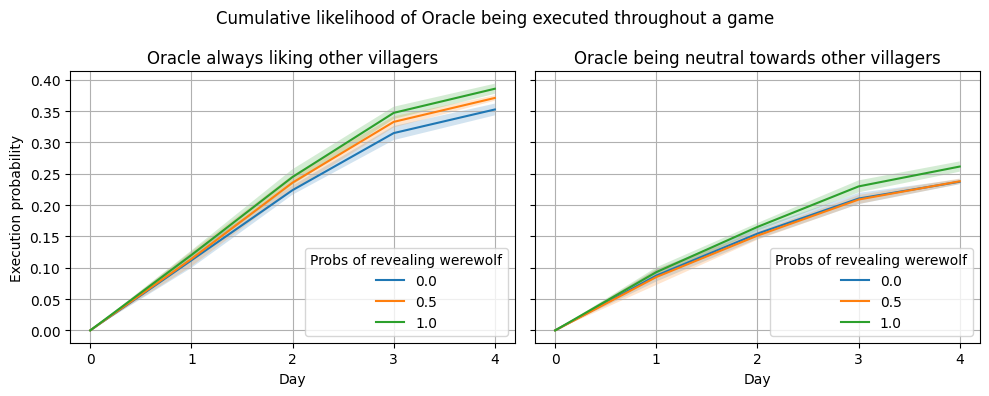

In [175]:
# 3
[tolerant_mean(l) for l in all_likes]
# y_neutrals, y_neutrals_std = [tolerant_mean(l) for l in all_neutrals]

[tolerant_mean(l) for l in all_neutrals]
#     ax.plot(np.arange(len(y))+1, y, label=i+1)
#     ax.fill_between(np.arange(len(y))+1, y-std, y+std, alpha=0.1)

# print(f_oneway(y_l.data, y_n.data))
# ttest_ind(y_l.data, y_n.data)
# y_likes
# std.data

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
x = [0, 1, 2, 3 ,4]
x_tick_labels = [0, 1 ,2 ,3, 4]

for (y, std) , p in zip([tolerant_mean(l) for l in all_likes], [0.0, 0.5, 1.0]):
    #ax1.plot(x, np.cumsum([i * o_results[l_key][0]['1'] for i in o_results[l_key][0]['2']]))
    ax1.plot(x, np.cumsum(y), label=p)
    ax1.fill_between(x, np.cumsum(y)-std, np.cumsum(y)+std, alpha=0.2)

for (y, std), p in zip([tolerant_mean(l) for l in all_neutrals], [0.0, 0.5, 1.0]):
    # ax2.plot(x, np.cumsum([i * o_results[l_key][0]['1'] for i in o_results[l_key][0]['2']]))
    ax2.plot(x, np.cumsum(y), label=p)
    ax2.fill_between(x, np.cumsum(y)-std, np.cumsum(y)+std, alpha=0.2)

fig.suptitle("Cumulative likelihood of Oracle being executed throughout a game")
ax1.set_xticks([0,1,2,3,4], x_tick_labels)
ax1.set_xlabel("Day")
ax1.set_ylabel("Execution probability")
ax1.grid()
ax1.set_title("Oracle always liking other villagers")
ax1.legend(title="Probs of revealing werewolf", loc='lower right')

ax2.set_xticks([0,1,2,3,4], x_tick_labels)
ax2.set_xlabel("Day")
ax2.grid()
ax2.set_title("Oracle being neutral towards other villagers")
ax2.legend(title="Probs of revealing werewolf", loc='lower right')

fig.tight_layout()
plt.plot()



In [139]:
f_oneway(o_results['1_0.0'][0]['2'], o_results['0_1.0'][0]['2'])

F_onewayResult(statistic=7.879804435266979e-33, pvalue=1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

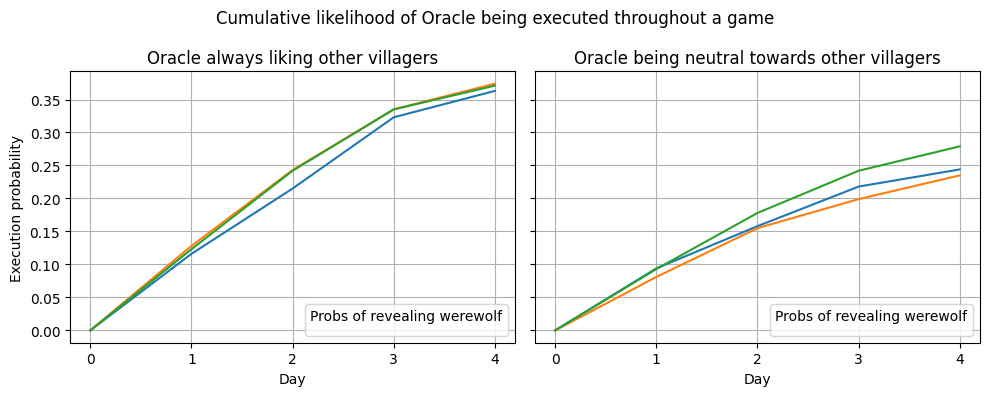

In [121]:
import matplotlib.pyplot as plt


# rescale for 1 plot to go to 0.27
# rescale for 0.36 

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

x = [0, 1, 2, 3 ,4]
x_tick_labels = [0, 1 ,2 ,3, 4]

likes = [k for k in list(o_results.keys()) if k.startswith('1_')]
neutrals = [k for k in list(o_results.keys()) if k.startswith('0_')]

for l_key in likes:
    ax1.plot(x, np.cumsum([i * o_results[l_key][0]['1'] for i in o_results[l_key][0]['2']]))

for l_key in neutrals:
    ax2.plot(x, np.cumsum([i * o_results[l_key][0]['1'] for i in o_results[l_key][0]['2']]))

fig.suptitle("Cumulative likelihood of Oracle being executed throughout a game")
ax1.set_xticks([0,1,2,3,4], x_tick_labels)
ax1.set_xlabel("Day")
ax1.set_ylabel("Execution probability")
ax1.grid()
ax1.set_title("Oracle always liking other villagers")
ax1.legend(title="Probs of revealing werewolf", loc='lower right')

# fig.suptitle("Cumulative likelihood of Oracle being executed throughout a game")
# ax1.plot(x, np.cumsum([i * y_1_0_total for i in y_1_0]), label="0.0")
# ax1.plot(x, np.cumsum([i * y_1_50_total for i in y_1_50]), label="0.5")
# ax1.plot(x, np.cumsum([i * y_1_100_total for i in y_1_100]), label="1.0")
# ax1.set_xticks([0,1,2,3,4], x_tick_labels)
# ax1.set_xlabel("Day")
# ax1.set_ylabel("Execution probability")
# ax1.grid()
# ax1.set_title("Oracle always liking other villagers")
# ax1.legend(title="Probs of revealing werewolf", loc='lower right')


# ax2.plot(x, np.cumsum([i * y_0_0_total for i in y_0_0]), label="0.0")
# ax2.plot(x, np.cumsum([i * y_0_50_total for i in y_0_50]),label="0.5")
# ax2.plot(x, np.cumsum([i * y_0_100_total for i in y_0_100]),label="1.0")
ax2.set_xticks([0,1,2,3,4], x_tick_labels)
ax2.set_xlabel("Day")
ax2.grid()
ax2.set_title("Oracle being neutral towards other villagers")
ax2.legend(title="Probs of revealing werewolf", loc='lower right')


# y = [0.0, 0.372, 0.266, 0.274, 0.088]
# y_dv = 0.27
# [i/y_dv for i in y]
# cum_sum = np.cumsum([i/y_dv for i in y])

# y_likes = [0.000, 0.278, 0.348, 0.264, 0.111]
# y_l_div = 0.36
# plt.plot(x, np.cumsum([i * y_dv for i in y]))
# plt.plot(x, np.cumsum([i*y_l_div for i in y_likes]))
# plt.xticks([0,1,2,3,4], x_tick_labels)
fig.tight_layout()
plt.plot()

[]

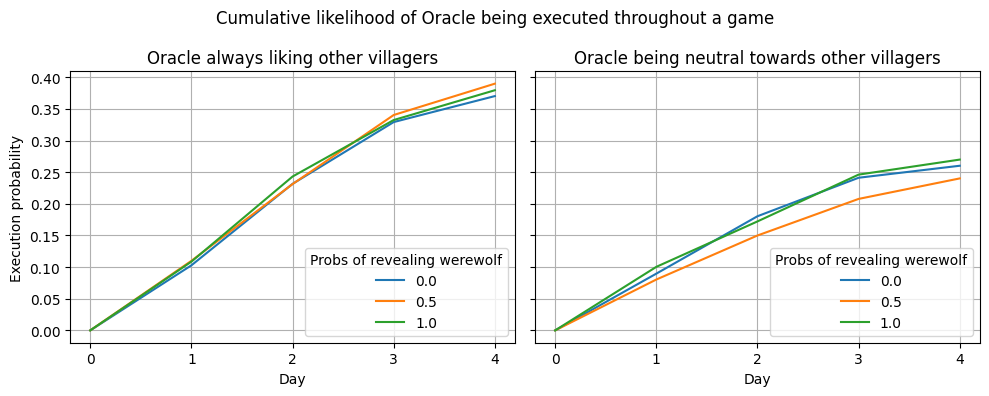

In [99]:
import matplotlib.pyplot as plt


# rescale for 1 plot to go to 0.27
# rescale for 0.36 

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

x = [0, 1, 2, 3 ,4]
x_tick_labels = [0, 1 ,2 ,3, 4]


y_1_0 = [0.000, 0.278, 0.348, 0.264, 0.111]
y_1_0_total = 0.37


y_1_50 = [0.000, 0.282, 0.311, 0.280, 0.127]
y_1_50_total = 0.39


y_1_100 = [0.000, 0.286, 0.354, 0.235, 0.124]
y_1_100_total = 0.38


y_0_0 = [0.000, 0.345, 0.349, 0.234, 0.073]
y_0_0_total = 0.26


y_0_50 = [0.000, 0.335, 0.290, 0.241, 0.135]
y_0_50_total = 0.24


y_0_100 = [0.000, 0.372, 0.266, 0.274, 0.088]
y_0_100_total = 0.27

fig.suptitle("Cumulative likelihood of Oracle being executed throughout a game")
ax1.plot(x, np.cumsum([i * y_1_0_total for i in y_1_0]), label="0.0")
ax1.plot(x, np.cumsum([i * y_1_50_total for i in y_1_50]), label="0.5")
ax1.plot(x, np.cumsum([i * y_1_100_total for i in y_1_100]), label="1.0")
ax1.set_xticks([0,1,2,3,4], x_tick_labels)
ax1.set_xlabel("Day")
ax1.set_ylabel("Execution probability")
ax1.grid()
ax1.set_title("Oracle always liking other villagers")
ax1.legend(title="Probs of revealing werewolf", loc='lower right')


ax2.plot(x, np.cumsum([i * y_0_0_total for i in y_0_0]), label="0.0")
ax2.plot(x, np.cumsum([i * y_0_50_total for i in y_0_50]),label="0.5")
ax2.plot(x, np.cumsum([i * y_0_100_total for i in y_0_100]),label="1.0")
ax2.set_xticks([0,1,2,3,4], x_tick_labels)
ax2.set_xlabel("Day")
ax2.grid()
ax2.set_title("Oracle being neutral towards other villagers")
ax2.legend(title="Probs of revealing werewolf", loc='lower right')


# y = [0.0, 0.372, 0.266, 0.274, 0.088]
# y_dv = 0.27
# [i/y_dv for i in y]
# cum_sum = np.cumsum([i/y_dv for i in y])

# y_likes = [0.000, 0.278, 0.348, 0.264, 0.111]
# y_l_div = 0.36
# plt.plot(x, np.cumsum([i * y_dv for i in y]))
# plt.plot(x, np.cumsum([i*y_l_div for i in y_likes]))
# plt.xticks([0,1,2,3,4], x_tick_labels)
fig.tight_layout()
plt.plot()


# x_tick_labels = ["Accusation", "Accusation", "Voting"]
# for day, color, linestyle in zip(range(stacked_info.shape[0]), colors, line_styles):
#     plt.plot(list(range(stacked_info.shape[1])), stacked_info[:,:,indicator_id][day], linewidth=2.0, linestyle=linestyle, color=color, label=f'Day {day+1}')
#     plt.xticks([0,1,2], x_tick_labels, rotation=40)
#     plt.legend()
#     plt.grid(True)
#     plt.suptitle(indicator_title)
#     plt.plot()

In [15]:
# likelihood that oracle gets killed round 1, 2, 3, 4
# villager gets killed round 1, 2, 3, 4

wins, replays, o_ids = play_recurrent_game_with_oracle(env, 
                                                        random_approval_wolf, 
                                                        trained_approval_agent, 
                                                        num_times=100, 
                                                        hidden_state_size=256, 
                                                        voting_type="approval", 
                                                        static_villager_policy="oracle",
                                                        vtc_other_villagers=1,
                                                        p=0.0)


In [18]:
len(replays)

100

In [68]:
def _when_did_oracle_get_killed(game, id):
    '''
        What day and was he killed by votes or by werewolves
    '''
    just_votes = []
    just_kills = []
    for step in game:
        if step['phase'] == Phase.VOTING:
            if len(step["executed"]) == 1:
                if step['executed'][0] == id:
                    return step['day'], 0
            else:
                who_was_killed = list(set(step['executed']) - set(just_votes[-1]['executed']))[0]
                if who_was_killed == id:
                    return step['day'], 0
                
            just_votes.append(step)
        
        if step['phase'] == Phase.NIGHT:

            if len(step["killed"]) == 1:
                if step['killed'][0] == id:
                    return step['day'], 1
            else:
                who_was_killed = list(set(step['killed']) - set(just_kills[-1]['killed']))[0]
                if who_was_killed == id:
                    return step['day'], 1

            just_kills.append(step)              

    return -1, -1

def print_oracle_info(replays, o_ids):
    # day, ty = [(_when_did_oracle_get_killed(replay, o_id)) for replay, o_id in zip(replays,o_ids)]
    day, ty = list(zip(*[(_when_did_oracle_get_killed(replay, o_id)) for replay, o_id in zip(replays,o_ids)]))
    game_winner = [replay[-1]['winners'] for replay in replays]
    df = pd.DataFrame({"day_oracle_killed": list(day), "way_oracle_killed": list(ty), "game_result": game_winner})
    
    oracle_executions = df[df['way_oracle_killed'] == 0]
    v_wins = df[df['game_result'] == 0]
    v_losses = df[df['game_result'] == 1]

    print(f'Likelihood that oracle lived to see end of a winning game : {len(v_wins[v_wins["day_oracle_killed"] == -1])/len(v_wins):.2f}')
    # print(f'Likelihood of Oracle being executed : {1 - oracle_executions["day_oracle_killed"].value_counts()[-1] / len(df)}')

    print(f'Oracle being executed in a winning game : {len(v_wins[(v_wins["day_oracle_killed"] != -1) & (v_wins["way_oracle_killed"] == 0)])/len(v_wins):.2f}')
    print(f'Oracle being executed in a losing game : {len(v_losses[(v_losses["day_oracle_killed"] != -1) & (v_losses["way_oracle_killed"] == 0)])/len(v_losses):.2f}')

    print(f'Likelihood of Oracle being executed : {len(oracle_executions)/len(df):.2f} ')
    print(f'\t Oracle executed in day 0 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 0])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 1 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 1])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 2 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 2])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 3 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 3])/len(oracle_executions):.3f}')
    print(f'\t Oracle executed in day 4 : {len(oracle_executions[oracle_executions["day_oracle_killed"] == 4])/len(oracle_executions):.3f}')



print_oracle_info(replays, o_ids)
#print(f'Day - {day}, Type - {ty}, Winner - {replays[0][-1]["winners"]}')

Likelihood that oracle lived to see end of a winning game : 0.56
Oracle being executed in a winning game : 0.09
Oracle being executed in a losing game : 0.51
Likelihood of Oracle being executed : 0.33 
	 Oracle executed in day 0 : 0.000
	 Oracle executed in day 1 : 0.121
	 Oracle executed in day 2 : 0.212
	 Oracle executed in day 3 : 0.455
	 Oracle executed in day 4 : 0.212


In [58]:
import pandas as pd

df = pd.DataFrame({"day_oracle_killed": list(day), "way_oracle_killed": list(ty), "game_result": game_winner})
df[df['way_oracle_killed'] == 0]
# 1 - df['day_oracle_killed'].value_counts()[-1] / len(df)
# df['day_oracle_killed'].value_counts()
# df['day_oracle_killed'].value_counts()

,day_oracle_killed,way_oracle_killed,game_result
0,3,0,1
2,3,0,1
3,3,0,1
4,3,0,1
6,4,0,1
9,3,0,1
17,1,0,1
20,1,0,1
23,2,0,1
28,3,0,1


In [50]:
df['way_oracle_killed'].value_counts()

-1    35
 0    33
 1    32
Name: way_oracle_killed, dtype: int64